## Frequency Arbitrage

![title](Frequency_Arbitrage.png)

In [116]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [117]:
SPX = web.DataReader(name='^GSPC',data_source='yahoo',start='2000-01-01')

In [118]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5071 entries, 2000-01-03 to 2020-02-28
Data columns (total 6 columns):
High         5071 non-null float64
Low          5071 non-null float64
Open         5071 non-null float64
Close        5071 non-null float64
Volume       5071 non-null int64
Adj Close    5071 non-null float64
dtypes: float64(5), int64(1)
memory usage: 277.3 KB


In [119]:
SPX = SPX[['Adj Close']]

### Main idea

For the daily volatility / weekly volatility arbitrage (also with the pattern that weekly historical volatility < daily historical volatility):

Assume that $S_{t}$ follows the following SDE:

$\frac {dS}{S} = \mu_{t} dt + \sigma_{t}dW_{1,t}$

By Ito's lemma,

$dlnS_{t} = \frac {dS}{S} - \frac{\sigma^{2}_{t}}{2}dt$

Integrate between $T_{1}$ and $T_{2}$,

$lnS_{T_{2}} - lnS_{T_{1}} = \int_{T_{1}}^{T_{2}}\frac {dS}{S} - \frac{1}{2}\int_{T_{1}}^{T_{2}}\sigma^2_{t}dt$

The stochastic integral $\int_{T_{1}}^{T_{2}}\frac {dS}{S}$ can be interpreted as holding $\frac{1}{S_{t}}$ share of risky asset $S$ between time $T_{1}$ and time $T_{2}$. 

And the second term on the right hand side is (half of) the cumulative instantaneous variance of the spot return between $T_{1}$ and $T_{2}$.

So similarly, following an intra-week mean reversion strategy, since we fix our money for investment to be $alpha$ dollars, in the beginning of the week our position is $\frac{\alpha}{S_{t_{i,1}}}$. And in the j-th day of the i-th week, our position is $\frac{\alpha}{S_{t_{i,j}}}$.

So the exposure of each day should be $\alpha(\frac{1}{S_{t_{i,1}}} - \frac{1}{S_{t_{i,j}}})$

### Demonstration

![title](demonstrate.png)

### Daily

In [121]:
SPX['log_return'] = np.log(SPX['Adj Close']).shift(-1) - np.log(SPX['Adj Close'])
SPX['delta'] = -1/SPX['Adj Close']

SPX['delta_exposure'] = SPX['delta'].diff()
SPX['cost'] = SPX['Adj Close'] * SPX['delta_exposure']

### weekly

In [122]:
SPX_weekly = SPX[['Adj Close']].copy()
SPX_weekly = SPX_weekly.resample('w').last()

In [123]:
SPX_weekly['log_return'] = np.log(SPX_weekly['Adj Close']).shift(-1) - np.log(SPX_weekly['Adj Close'])
SPX_weekly['delta'] = 1/SPX_weekly['Adj Close']

SPX_weekly['delta_exposure'] = SPX_weekly['delta'].diff()
SPX_weekly['cost'] = SPX_weekly['Adj Close'] * SPX_weekly['delta_exposure']

### Strategy

In [124]:
initial_account = 1000
cost = initial_account * (SPX['cost'].resample('w').sum() + SPX_weekly['cost'])[1:]

In [125]:
cum_ret = cost.cumsum()

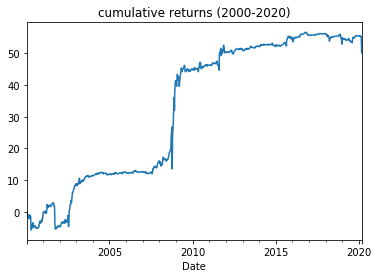

In [126]:
_ = cum_ret.plot(title='cumulative returns (2000-2020)')

Try a different way to compute cumulative returns to test the result.

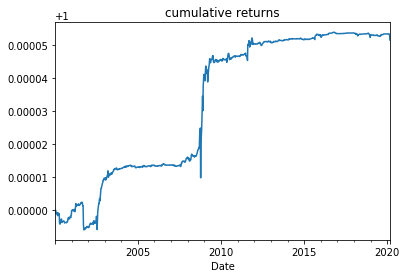

In [127]:
_ = (1+((SPX['log_return'].shift(1)*SPX['delta']).resample('w').sum())+ \
     (SPX_weekly['log_return'].shift(1)*SPX_weekly['delta'])).cumprod().plot(title = 'cumulative returns')

In [128]:
print('Done !')

Done !
